# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Citations

Dataset: This tech report (Chapter 3) describes the dataset and the methodology followed when collecting it in much greater detail. Please cite it if you intend to use this dataset.
[Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

[Normalization values for transforms:](https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data)

[Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) - was referred by a very nice technical mentor I reached out to after going crazy all weekend with a feed-forward model that would not learn! :)



## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [42]:
# My additional imports
import torchvision.datasets as datasets


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [25]:
# Define transforms:
# I did not calculate the normalization values myself, I was able to find them for CIFAR10 at Stack Overflow
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Directories for files:
data_dir_train = '/Users/lauran_kio/Documents/Courses/Exercises/deep-learning-v2-pytorch/intro-to-pytorch/DeepLearningPyTorch/CIFAR-10-images/train'
data_dir_test = '/Users/lauran_kio/Documents/Courses/Exercises/deep-learning-v2-pytorch/intro-to-pytorch/DeepLearningPyTorch/CIFAR-10-images/test'

batch_size = 256

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(data_dir_train, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(data_dir_test, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [34]:
image, label = next(iter(trainloader))

#Make sure the tensor looks as expected!
print(type(image))
print(image.shape)
print(image[3])
print(label.shape)
print(label)

# Flatten:
images_flat = image.view(image.shape[0], -1)
print(images_flat.shape)

<class 'torch.Tensor'>
torch.Size([256, 3, 32, 32])
tensor([[[-0.4196, -0.5137, -0.5294,  ..., -0.3412, -0.3882, -0.3961],
         [-0.4588, -0.5137, -0.4510,  ..., -0.3804, -0.3569, -0.4353],
         [-0.4745, -0.4588, -0.5059,  ..., -0.3490, -0.3569, -0.4667],
         ...,
         [-0.2235, -0.2314, -0.2392,  ..., -0.4353, -0.4039, -0.4275],
         [-0.3098, -0.2627, -0.2471,  ..., -0.4275, -0.3882, -0.4039],
         [-0.2784, -0.2784, -0.2863,  ..., -0.3020, -0.3333, -0.3490]],

        [[-0.2235, -0.3333, -0.3647,  ..., -0.2000, -0.2392, -0.2627],
         [-0.2706, -0.3490, -0.3020,  ..., -0.2314, -0.2078, -0.3020],
         [-0.2941, -0.3020, -0.3647,  ..., -0.2157, -0.2157, -0.3412],
         ...,
         [-0.0667, -0.0745, -0.0824,  ..., -0.3333, -0.3176, -0.3412],
         [-0.1451, -0.0980, -0.0902,  ..., -0.3176, -0.2941, -0.3020],
         [-0.1373, -0.1373, -0.1373,  ..., -0.1765, -0.1922, -0.2078]],

        [[-0.1922, -0.3020, -0.3255,  ..., -0.1216, -0.1686, -0.

In [26]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = (images[i].numpy())/ 2 + 0.5 #undo the normalization
        plt.imshow(image.T)
        plt.show()

ship


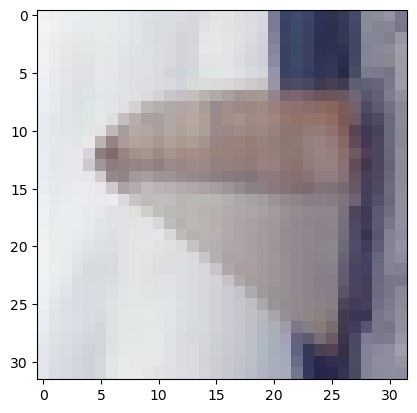

dog


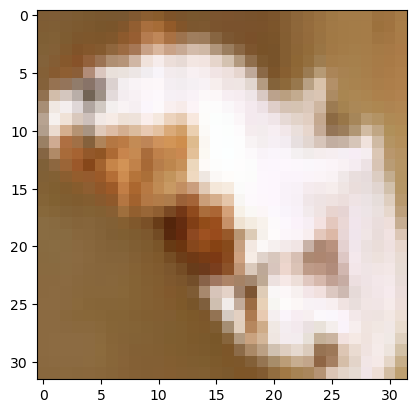

bird


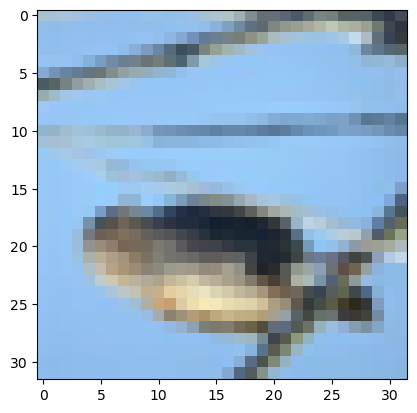

truck


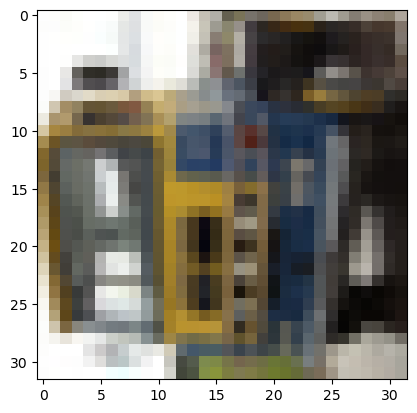

bird


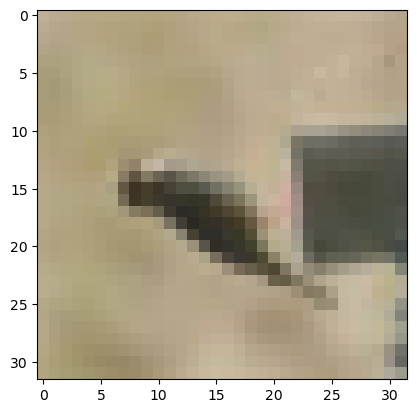

In [27]:
# Explore data
show5(trainloader)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [43]:
## YOUR CODE HERE ##
## Let's start with a feed-forward network with these layers:
# fc1 (3072 inputs, 1024 out)
# fc2 1024, 784
# fc3 - 784, 128
# fc4 - 128, 64
# fc5 - 64, 10

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        ''' First define the layers of the network: '''
        # Inputs to hidden layer 1 Linear transformation
        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 784)
        self.fc3 = nn.Linear(784, 128) #784 inputs, 128 outputs
        # Hidden layer 1 to hidden layer 2 Linear transformation
        self.fc4 = nn.Linear(128, 64)
        # Hidden layer 2 to hidden Output layer 
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        # Pass the input tensor x through each of our operations
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc5(x), dim=1)

        return x
    
#''''''Look at the model:''''''
model = Network()
model

Network(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [46]:
## YOUR CODE HERE ##

learn_rate = 0.0001
epochs = 15
steps = 0

# Loss function:
criterion = nn.CrossEntropyLoss()

# Optimizer:
optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [47]:
## YOUR CODE HERE ##
model = Network()

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        images, labels = data
    #for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        ## For each training pass, you do a validation pass!!
        
        test_loss = 0
        accuracy = 0
        
        ## Turn off gradients - only needed for training
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()
            # Feed test batch into model:
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
            
                # Get the class proabilities:
                ps = torch.exp(log_ps)
                # Get the class with the highest probability for each sample:
                top_p, top_class = ps.topk(1, dim=1)

                # Get a tensor with the correct predictions by comparing top_class to the labels:
                equals = top_class == labels.view(*top_class.shape)
        
                # Calculate the accuracy by taking the mean of our new equals tensor - after floatifying it
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        # set model back to train mode
        model.train()
        
        # Update the train_losses and test_losses lists:
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
             "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
             "Test Loss: {:.3f}.. ".format(test_loss/len(trainloader)),
             "Test Accuracy:  {:.3f}.. ".format(accuracy/len(trainloader)))

Epoch: 1/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 
Epoch: 2/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 
Epoch: 3/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 
Epoch: 4/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 
Epoch: 5/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 
Epoch: 6/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 
Epoch: 7/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 
Epoch: 8/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 
Epoch: 9/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 
Epoch: 10/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 
Epoch: 11/15..  Training Loss: 2.306..  Test Loss: 0.471..  Test Accuracy:  0.021.. 


KeyboardInterrupt: 

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**

